In [1]:
# Import Libraries

import numpy as np
import pandas as pd
from pathlib import Path
from pandas.tseries.offsets import DateOffset
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Supress Pandas Dataframe chain warning
pd.set_option('mode.chained_assignment', None)

In [2]:
# User Inputs

assetNames = ['crudeOil', 'Gold', 'Russel2000', 'S&P500', 'EUR-USD', 'GBP-JPY', 'BTC-USD', 'ETH-USD']


# Portfolio Metrics
initial = 10000
riskFree = 0.01
risk=0.1

## Strategy Functions

### Buy and Hold Strategy

In [3]:
# Buy and Hold Strategy Returns

def buyHoldReturns(algoData):

    # Make first return and signal 0 so all cumulative returns start at 1
    algoData["ActualReturns"][0] = 0
    algoData["Signal"][0] = 0

    algoData['cumBuyHoldReturns'] = (1+algoData['ActualReturns']).cumprod()
    
    returns = algoData[['Signal', "ActualReturns", 'cumBuyHoldReturns']]
    
    return returns


### MACD Strategy

In [4]:
# MACD Strategy Function

def macdStrategy(algoData, risk):
    
    signal = [0]
    position = False
    price = 0
    
    for ind in range(1, algoData.shape[0]):
    
        if((algoData['MACDline'][ind] > algoData['MACDSignal'][ind]) & (algoData['MACDline'][ind-1] > algoData['MACDSignal'][ind-1])):
        
            signal.append(1)
            position = True
            price = algoData['Close'][ind]
    
        elif ((algoData['MACDline'][ind] < algoData['MACDSignal'][ind]) & (algoData['MACDline'][ind-1] < algoData['MACDSignal'][ind-1])):

            signal.append(-1)
            position = True
            price = algoData['Close'][ind]
            
        elif ((position == True) & (signal[-1] == 1) & (algoData['Close'][ind] < price*(1-risk))):
            position = False
            signal.append(0)
            price = algoData['Close'][ind]
        elif((position == True) & (signal[-1] == -1) & (algoData['Close'][ind] > price*(1+risk))):
            position = False
            signal.append(0)
            price = algoData['Close'][ind]
            
        else:
        
            signal.append(np.nan)
        
    return signal

In [5]:
# MACD Strategy returns

def macdReturns(algoData, risk):

    # Make first return 0 so all cumulative returns start at 1
    algoData["ActualReturns"][0] = 0

    algoData['MACDStrategy'] = macdStrategy(algoData, risk)
    algoData['MACDStrategy'] = algoData['MACDStrategy'].ffill()
    algoData['MACDStrategyReturns'] = algoData['ActualReturns'] * algoData['MACDStrategy']
    algoData['MACDStrategyReturns'] = algoData['MACDStrategyReturns'].fillna(0)
    algoData['cumMACDReturns'] = (1 + algoData['MACDStrategyReturns']).cumprod()
    
    returns = algoData[['MACDStrategy', 'MACDStrategyReturns', 'cumMACDReturns']]
    
    return returns


### RSI Strategy

In [6]:
# RSI Strategy Function

def rsiSystem(algoData, risk):
    
    signal = [0]
    position = False
    price = 0
    

    for ind in range(1, algoData.shape[0]):

        if ((algoData['RSIline'][ind] > 80) & (algoData['RSIline'][ind-1] < 80) & (position == False)):
            signal.append(-1)
            position = True
            price = algoData['Close'][ind]
        elif ((algoData['RSIline'][ind] < 20) & (algoData['RSIline'][ind-1] > 20) & (position == False)):
            signal.append(1)
            position = True
            price = algoData['Close'][ind]
        elif ((algoData['RSIline'][ind] < 50) & (algoData['RSIline'][ind-1] > 50) & (position == True) & (signal[-1]==1)):
            signal.append(0)
            position = False
            price = algoData['Close'][ind]
        elif ((algoData['RSIline'][ind] > 50) & (algoData['RSIline'][ind-1] < 50) & (position == True) & (signal[-1]==-1)):
            signal.append(0)
            position = False
            price = algoData['Close'][ind]
        elif ((position == True) & (signal[-1] == 1) & (algoData['Close'][ind] < price*(1-risk))):
            position = False
            signal.append(0)
            price = algoData['Close'][ind]
        
        elif ((position == True) & (signal[-1] == -1) & (algoData['Close'][ind] > price*(1+risk))):
            position = False
            signal.append(0)
            price = algoData['Close'][ind]   
            
        else:
            signal.append(np.nan)
            
            
    return signal

In [7]:
# RSI Strategy returns

def rsiReturns(algoData, risk):

    # Make first return 0 so all cumulative returns start at 1
    algoData["ActualReturns"][0] = 0

    algoData['RSIStrategy'] = rsiSystem(algoData, risk)
    algoData['RSIStrategy'] = algoData['RSIStrategy'].ffill()
    algoData['RSIStrategyReturns'] = algoData['ActualReturns'] * algoData['RSIStrategy']
    algoData['RSIRayStrategyReturns'] = algoData['RSIStrategyReturns'].fillna(0)
    algoData['cumRSIReturns'] = (1 + algoData['RSIStrategyReturns']).cumprod()
    
    returns = algoData[['RSIStrategy', 'RSIStrategyReturns', 'cumRSIReturns']]
    
    return returns


### Impulse Strategy

In [8]:
# Impulse System Function

def impulseSystem(algoData, risk):
    
    signal = [0]
    position = False
    price = 0
    
    for ind in range(1, algoData.shape[0]):
    
        if((algoData['EMAShort'][ind] > algoData['EMAShort'][ind-1]) & (algoData['EMALong'][ind] > algoData['EMALong'][ind-1]) & (algoData['MACDHistogram'][ind] > algoData['MACDHistogram'][ind-1])):
        
            signal.append(1)
            position = True
            price=algoData['Close'][ind]
    
        elif ((algoData['EMAShort'][ind] < algoData['EMAShort'][ind-1]) & (algoData['EMALong'][ind] < algoData['EMALong'][ind-1]) & (algoData['MACDHistogram'][ind] < algoData['MACDHistogram'][ind-1])):

            signal.append(-1)
            position = True
            price=algoData['Close'][ind]
            
            
            
        elif ((position == True) & (signal[-1] == 1) & (algoData['Close'][ind] < price*(1-risk))):
            position = False
            signal.append(0)
            price = algoData['Close'][ind]
        
        elif ((position == True) & (signal[-1] == -1) & (algoData['Close'][ind] > price*(1+risk))):
            position = False
            signal.append(0)
            price = algoData['Close'][ind]   
    
        else:
        
            signal.append(np.nan)
           
    return signal

In [9]:
# Impulse Strategy returns

def impulseReturns(algoData, risk):

    # Make first return 0 so all cumulative returns start at 1
    algoData["ActualReturns"][0] = 0

    algoData['ImpulseStrategy'] = impulseSystem(algoData, risk)
    algoData['ImpulseStrategy'] = algoData['ImpulseStrategy'].ffill()
    algoData['ImpulseStrategyReturns'] = algoData['ActualReturns'] * algoData['ImpulseStrategy']
    algoData['ImpulseStrategyReturns'] = algoData['ImpulseStrategyReturns'].fillna(0)
    algoData['cumImpulseReturns'] = (1 + algoData['ImpulseStrategyReturns']).cumprod()
    
    returns = algoData[['ImpulseStrategy', 'ImpulseStrategyReturns', 'cumImpulseReturns']]
    
    return returns


### Bollinger Bands Strategy

In [10]:
# Bollinger Bands Function

def bbStrategy(algoData, risk):
    
    signal = [0]
    position = False
    price=0
    
    for ind in range(1, algoData.shape[0]):
        
        if ((algoData['Close'][ind] > algoData['upperBB'][ind]) & (algoData['Close'][ind-1] < algoData['upperBB'][ind-1]) & (position == False)):
            signal.append(-1)
            position = True
            price = algoData['Close'][ind]
        elif ((algoData['Close'][ind] < algoData['lowerBB'][ind]) & (algoData['Close'][ind-1] > algoData['lowerBB'][ind-1]) & (position == False)):
            signal.append(1)
            position = True
            price = algoData['Close'][ind]
        elif ((algoData['Close'][ind] < algoData['middleBB'][ind]) & (algoData['Close'][ind-1] > algoData['middleBB'][ind-1]) & (position == True)):
            signal.append(0)
            position = False
            price = algoData['Close'][ind]
        elif ((algoData['Close'][ind] > algoData['middleBB'][ind]) & (algoData['Close'][ind-1] < algoData['middleBB'][ind-1]) & (position == True)):
            signal.append(0)
            position = False
            price = algoData['Close'][ind]
            
        elif ((position == True) & (signal[-1] == 1) & (algoData['Close'][ind] < price*(1-risk))):
            position = False
            signal.append(0)
            price = algoData['Close'][ind]
        
        elif ((position == True) & (signal[-1] == -1) & (algoData['Close'][ind] > price*(1+risk))):
            position = False
            signal.append(0)
            price = algoData['Close'][ind]  
        else:
            signal.append(np.nan)
    
    return signal
    
    

In [11]:
# Bollinger Bands Strategy returns

def bollingerReturns(algoData, risk):

    # Make first return 0 so all cumulative returns start at 1
    algoData["ActualReturns"][0] = 0

    # Caluclate BB Strategy
    algoData['BBStrategy'] = bbStrategy(algoData, risk)
    algoData['BBStrategy'] = algoData['BBStrategy'].ffill()
    algoData['BBStrategyReturns'] = algoData['ActualReturns'] * algoData['BBStrategy']
    algoData['BBStrategyReturns'] = algoData['BBStrategyReturns'].fillna(0)
    algoData['cumBBReturns'] = (1 + algoData['BBStrategyReturns']).cumprod()

    returns = algoData[['BBStrategy', 'BBStrategyReturns', 'cumBBReturns']]
    
    return returns


### Combine all Strategy Returns

In [12]:
# Calculate all Strategy Returns and place in a dataframe 

def allReturnsData(algoData, risk):
    
    buyHoldReturn = buyHoldReturns(algoData)
    macdReturn = macdReturns(algoData, risk)
    rsiReturn = rsiReturns(algoData, risk)
    impulseReturn = impulseReturns(algoData, risk)
    bollingerReturn = bollingerReturns(algoData, risk)
    
    allReturns = pd.concat([buyHoldReturn, macdReturn, rsiReturn, impulseReturn, bollingerReturn], axis=1)
    allReturns = allReturns.dropna()
    
    return allReturns

## Results

### Cumulative Returns

In [13]:
def cumulativeStrategyReturnsPlot(allStrategyReturns, assetName):

    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=allStrategyReturns.index,
            y=allStrategyReturns['cumBuyHoldReturns'],
            name="Buy&Hold",
            line=dict(color="green")
        ))

    fig.add_trace(
        go.Scatter(
            x=allStrategyReturns.index,
            y=allStrategyReturns['cumMACDReturns'],
            name='MACD',
            line=dict(color="red")
        ))


    fig.add_trace(
        go.Scatter(
            x=allStrategyReturns.index,
            y=allStrategyReturns['cumRSIReturns'],
            name='RSI',
            line=dict(color="blue")
        ))

    fig.add_trace(
        go.Scatter(
            x=allStrategyReturns.index,
            y=allStrategyReturns['cumImpulseReturns'],
            name='Impulse System',
            line=dict(color="orange")
        ))

    fig.add_trace(
        go.Scatter(
            x=allStrategyReturns.index,
            y=allStrategyReturns['cumBBReturns'],
            name='Bollinger Bands',
            line=dict(color="purple")
        ))



    fig.update_layout(
        title={
            'text': "Cumulative Strategy Returns",
        },
        template='seaborn',
        xaxis=dict(autorange=True,
                  title_text='Date'),
        yaxis=dict(autorange=True,
                  title_text='Cumulative Returns'),
        legend=dict(
                orientation='h',
                yanchor='bottom',
                y=1,
                xanchor='right',
                x=1
    ))

    fileName = assetName+'_cumStrategyReturns.png'
    
    fig.write_image(fileName)
    
    return fig.show()
    
    

### Descriptive Statistics

In [14]:
 # Descriptive Statistics Results
    
def descriptiveStatsTable(allStrategyReturns, initial, riskFree, assetName):

    # Calculate Descriptive Statistics

    start_date = allStrategyReturns.index.min()
    end_date = allStrategyReturns.index.max()

    start = str(start_date.day)+'-'+str(start_date.month)+'-'+str(start_date.year)
    end = str(end_date.day)+'-'+str(end_date.month)+'-'+str(end_date.year)

    days = (end_date - start_date).days
    years = days/365

    init_investment = initial
    rf = riskFree

    buyHold_start = init_investment
    macd_start = init_investment
    rsi_start = init_investment
    impulse_start = init_investment
    bollinger_start = init_investment

    buyHold_end = round(allStrategyReturns['cumBuyHoldReturns'][-1] * init_investment,2)
    macd_end = round(allStrategyReturns['cumMACDReturns'][-1] * init_investment,2)
    rsi_end = round(allStrategyReturns['cumRSIReturns'][-1] * init_investment,2)
    impulse_end = round(allStrategyReturns['cumImpulseReturns'][-1] * init_investment,2)
    bollinger_end = round(allStrategyReturns['cumBBReturns'][-1] * init_investment,2)

    buyHold_max_dailyReturn = round(allStrategyReturns['ActualReturns'].max(),6)
    macd_max_dailyReturn = round(allStrategyReturns['MACDStrategyReturns'].max(),6)
    rsi_max_dailyReturn = round(allStrategyReturns['RSIStrategyReturns'].max(),6)
    impulse_max_dailyReturn = round(allStrategyReturns['ImpulseStrategyReturns'].max(),6)
    bollinger_max_dailyReturn = round(allStrategyReturns['BBStrategyReturns'].max(),6)

    buyHold_min_dailyReturn = round(allStrategyReturns['ActualReturns'].min(),6)
    macd_min_dailyReturn = round(allStrategyReturns['MACDStrategyReturns'].min(),6)
    rsi_min_dailyReturn = round(allStrategyReturns['RSIStrategyReturns'].min(),6)
    impulse_min_dailyReturn = round(allStrategyReturns['ImpulseStrategyReturns'].min(),6)
    bollinger_min_dailyReturn = round(allStrategyReturns['BBStrategyReturns'].min(),6)

    buyHold_max_drawdown = round(((allStrategyReturns['cumBuyHoldReturns'].min() - allStrategyReturns['cumBuyHoldReturns'].max())/allStrategyReturns['cumBuyHoldReturns'].max()),6)
    macd_max_drawdown = round(((allStrategyReturns['cumMACDReturns'].min() - allStrategyReturns['cumMACDReturns'].max())/allStrategyReturns['cumMACDReturns'].max()),6)
    rsi_max_drawdown = round(((allStrategyReturns['cumRSIReturns'].min() - allStrategyReturns['cumRSIReturns'].max())/allStrategyReturns['cumRSIReturns'].max()),6)
    impulse_max_drawdown = round(((allStrategyReturns['cumImpulseReturns'].min() - allStrategyReturns['cumImpulseReturns'].max())/allStrategyReturns['cumImpulseReturns'].max()),6)
    bollinger_max_drawdown = round(((allStrategyReturns['cumBBReturns'].min() - allStrategyReturns['cumBBReturns'].max())/allStrategyReturns['cumBBReturns'].max()),6)
    
    buyHoldSignals = allStrategyReturns.Signal[(allStrategyReturns['Signal'] == 1) | (allStrategyReturns['Signal'] == -1)].count()
    macdSignals = allStrategyReturns.MACDStrategy[(allStrategyReturns['MACDStrategy'] == 1) | (allStrategyReturns['MACDStrategy'] == -1)].count()
    rsiSignals = allStrategyReturns.RSIStrategy[(allStrategyReturns['RSIStrategy'] == 1) | (allStrategyReturns['RSIStrategy'] == -1)].count()
    impulseSignals = allStrategyReturns.ImpulseStrategy[(allStrategyReturns['ImpulseStrategy'] == 1) | (allStrategyReturns['ImpulseStrategy'] == -1)].count()
    bollingerSignals = allStrategyReturns.BBStrategy[(allStrategyReturns['BBStrategy'] == 1) | (allStrategyReturns['BBStrategy'] == -1)].count()
    
    buyHoldPos = allStrategyReturns.ActualReturns[(allStrategyReturns['ActualReturns'] > 0)].count()
    macdPos = allStrategyReturns.MACDStrategyReturns[(allStrategyReturns['MACDStrategyReturns'] > 0)].count()
    rsiPos = allStrategyReturns.RSIStrategyReturns[(allStrategyReturns['RSIStrategyReturns'] > 0)].count()
    impulsePos = allStrategyReturns.ImpulseStrategyReturns[(allStrategyReturns['ImpulseStrategyReturns'] > 0)].count()
    bollingerPos = allStrategyReturns.BBStrategyReturns[(allStrategyReturns['BBStrategyReturns'] > 0)].count()
    
    buyHoldPosPerc = round((buyHoldPos/buyHoldSignals),6)
    macdPosPerc = round((macdPos/macdSignals),6)
    rsiPosPerc = round((rsiPos/rsiSignals),6)
    impulsePosPerc = round((impulsePos/impulseSignals),6)
    bollingerPosPerc = round((bollingerPos/bollingerSignals),6)
    
    buyHoldPosSum = allStrategyReturns.ActualReturns[(allStrategyReturns['ActualReturns'] > 0)].sum()
    macdPosSum = allStrategyReturns.MACDStrategyReturns[(allStrategyReturns['MACDStrategyReturns'] > 0)].sum()
    rsiPosSum = allStrategyReturns.RSIStrategyReturns[(allStrategyReturns['RSIStrategyReturns'] > 0)].sum()
    impulsePosSum = allStrategyReturns.ImpulseStrategyReturns[(allStrategyReturns['ImpulseStrategyReturns'] > 0)].sum()
    bollingerPosSum = allStrategyReturns.BBStrategyReturns[(allStrategyReturns['BBStrategyReturns'] > 0)].sum()
    
    buyHoldPosAvg = round((buyHoldPosSum/buyHoldPos),6)
    macdPosAvg = round((macdPosSum/macdPos),6)
    rsiPosAvg = round((rsiPosSum/rsiPos),6)
    impulsePosAvg = round((impulsePosSum/impulsePos),6)
    bollingerPosAvg = round((bollingerPosSum/bollingerPos),6)
    
    buyHoldNeg = allStrategyReturns.ActualReturns[(allStrategyReturns['ActualReturns'] < 0)].count()
    macdNeg = allStrategyReturns.MACDStrategyReturns[(allStrategyReturns['MACDStrategyReturns'] < 0)].count()
    rsiNeg = allStrategyReturns.RSIStrategyReturns[(allStrategyReturns['RSIStrategyReturns'] < 0)].count()
    impulseNeg = allStrategyReturns.ImpulseStrategyReturns[(allStrategyReturns['ImpulseStrategyReturns'] < 0)].count()
    bollingerNeg = allStrategyReturns.BBStrategyReturns[(allStrategyReturns['BBStrategyReturns'] < 0)].count()
    
    
    buyHoldNegPerc = round((buyHoldNeg/buyHoldSignals),6)
    macdNegPerc = round((macdNeg/macdSignals),6)
    rsiNegPerc = round((rsiNeg/rsiSignals),6)
    impulseNegPerc = round((impulseNeg/impulseSignals),6)
    bollingerNegPerc = round((bollingerNeg/bollingerSignals),6)
    
    
    buyHoldNegSum = allStrategyReturns.ActualReturns[(allStrategyReturns['ActualReturns'] < 0)].sum()
    macdNegSum = allStrategyReturns.MACDStrategyReturns[(allStrategyReturns['MACDStrategyReturns'] < 0)].sum()
    rsiNegSum = allStrategyReturns.RSIStrategyReturns[(allStrategyReturns['RSIStrategyReturns'] < 0)].sum()
    impulseNegSum = allStrategyReturns.ImpulseStrategyReturns[(allStrategyReturns['ImpulseStrategyReturns'] < 0)].sum()
    bollingerNegSum = allStrategyReturns.BBStrategyReturns[(allStrategyReturns['BBStrategyReturns'] < 0)].sum()
    
    buyHoldNegAvg = round((buyHoldNegSum/buyHoldNeg),6)
    macdNegAvg = round((macdNegSum/macdNeg),6)
    rsiNegAvg = round((rsiNegSum/rsiNeg),6)
    impulseNegAvg = round((impulseNegSum/impulseNeg),6)
    bollingerNegAvg = round((bollingerNegSum/bollingerNeg),6)
    
    buyHold_annualReturn = allStrategyReturns['ActualReturns'].apply(lambda x: (1+x)).cumprod().iloc[-1]**(1/years) - 1
    macd_annualReturn = allStrategyReturns['MACDStrategyReturns'].apply(lambda x: (1+x)).cumprod().iloc[-1]**(1/years) - 1
    rsi_annualReturn = allStrategyReturns['RSIStrategyReturns'].apply(lambda x: (1+x)).cumprod().iloc[-1]**(1/years) - 1
    impulse_annualReturn = allStrategyReturns['ImpulseStrategyReturns'].apply(lambda x: (1+x)).cumprod().iloc[-1]**(1/years) - 1
    bollinger_annualReturn = allStrategyReturns['BBStrategyReturns'].apply(lambda x: (1+x)).cumprod().iloc[-1]**(1/years) - 1


    buyHold_annualVol = allStrategyReturns['ActualReturns'].apply(lambda x: np.log(1+x)).std()*np.sqrt(252)
    macd_annualVol = allStrategyReturns['MACDStrategyReturns'].apply(lambda x: np.log(1+x)).std()*np.sqrt(252)
    rsi_annualVol = allStrategyReturns['RSIStrategyReturns'].apply(lambda x: np.log(1+x)).std()*np.sqrt(252)
    impulse_annualVol = allStrategyReturns['ImpulseStrategyReturns'].apply(lambda x: np.log(1+x)).std()*np.sqrt(252)
    bollinger_annualVol = allStrategyReturns['BBStrategyReturns'].apply(lambda x: np.log(1+x)).std()*np.sqrt(252)

    buyHold_Sharpe = round((buyHold_annualReturn-rf)/buyHold_annualVol,2)
    macd_Sharpe = round((macd_annualReturn-rf)/macd_annualVol,2)
    rsi_Sharpe = round((rsi_annualReturn-rf)/rsi_annualVol,2)
    impulse_Sharpe = round((impulse_annualReturn-rf)/impulse_annualVol,2)
    bollinger_Sharpe = round((bollinger_annualReturn-rf)/bollinger_annualVol,2)


    buyHold_variance = allStrategyReturns['ActualReturns'].var()

    macd_covariance = allStrategyReturns['MACDStrategyReturns'].cov(allStrategyReturns['ActualReturns'])
    rsi_covariance = allStrategyReturns['RSIStrategyReturns'].cov(allStrategyReturns['ActualReturns'])
    impulse_covariance = allStrategyReturns['ImpulseStrategyReturns'].cov(allStrategyReturns['ActualReturns'])
    bollinger_covariance = allStrategyReturns['BBStrategyReturns'].cov(allStrategyReturns['ActualReturns'])

    buyHold_beta = 1

    macd_beta = round(macd_covariance/buyHold_variance,2)
    rsi_beta = round(rsi_covariance/buyHold_variance,2)
    impulse_beta = round(impulse_covariance/buyHold_variance,2)
    bollinger_beta = round(bollinger_covariance/buyHold_variance,2)
    

    # Table of Descriptive Statistics

    labels = ['Start Date', 'End Date','Initial Investment', 'Ending Investment','--------------------------',
              'Signals', 'Winning Trades', 'Losing Trades', '% Winning', '% Losing', 
              'Average Profit','Average Loss', '--------------------------', 
              'Max Daily Return','Min Daily Return', 'Max Drawdown', 'Annual Return',
              'Annual Volatility', 'Sharpe Ratio', 'Beta']


    buyHold_stats = [start, end,'${:,}'.format(buyHold_start), '${:,}'.format(buyHold_end), '--------------------------',
                     buyHoldSignals, buyHoldPos, buyHoldNeg,'{:.2%}'.format(buyHoldPosPerc),'{:.2%}'.format(buyHoldNegPerc), 
                     '{:.2%}'.format(buyHoldPosAvg), '{:.2%}'.format(buyHoldNegAvg), '--------------------------', 
                     '{:.2%}'.format(buyHold_max_dailyReturn), '{:.2%}'.format(buyHold_min_dailyReturn), 
                     '{:.2%}'.format(buyHold_max_drawdown), '{:.2%}'.format(buyHold_annualReturn), 
                     '{:.2%}'.format(buyHold_annualVol), buyHold_Sharpe, buyHold_beta]


    macd_stats = [start, end,'${:,}'.format(macd_start), '${:,}'.format(macd_end),'--------------------------', 
                  macdSignals, macdPos, macdNeg,'{:.2%}'.format(macdPosPerc),'{:.2%}'.format(macdNegPerc),
                  '{:.2%}'.format(macdPosAvg), '{:.2%}'.format(macdNegAvg), '--------------------------', 
                  '{:.2%}'.format(macd_max_dailyReturn), '{:.2%}'.format(macd_min_dailyReturn), 
                  '{:.2%}'.format(macd_max_drawdown), '{:.2%}'.format(macd_annualReturn), 
                  '{:.2%}'.format(macd_annualVol), macd_Sharpe, macd_beta]

    rsi_stats = [start, end, '${:,}'.format(rsi_start), '${:,}'.format(rsi_end),'--------------------------', 
                      rsiSignals, rsiPos, rsiNeg, '{:.2%}'.format(rsiPosPerc),
                      '{:.2%}'.format(rsiNegPerc), '{:.2%}'.format(rsiPosAvg), '{:.2%}'.format(rsiNegAvg), 
                      '--------------------------', '{:.2%}'.format(rsi_max_dailyReturn), 
                      '{:.2%}'.format(rsi_min_dailyReturn), '{:.2%}'.format(rsi_max_drawdown),
                      '{:.2%}'.format(rsi_annualReturn), '{:.2%}'.format(rsi_annualVol), 
                      rsi_Sharpe, rsi_beta]


    impulse_stats = [start, end, '${:,}'.format(impulse_start), '${:,}'.format(impulse_end), '--------------------------', 
                     impulseSignals, impulsePos, impulseNeg, '{:.2%}'.format(impulsePosPerc),'{:.2%}'.format(impulseNegPerc), 
                     '{:.2%}'.format(impulsePosAvg), '{:.2%}'.format(impulseNegAvg), '--------------------------', 
                     '{:.2%}'.format(impulse_max_dailyReturn), '{:.2%}'.format(impulse_min_dailyReturn), 
                     '{:.2%}'.format(impulse_max_drawdown), '{:.2%}'.format(impulse_annualReturn), 
                     '{:.2%}'.format(impulse_annualVol), impulse_Sharpe, impulse_beta]


    bollinger_stats = [start, end, '${:,}'.format(bollinger_start), '${:,}'.format(bollinger_end), '--------------------------',
                       bollingerSignals, bollingerPos, bollingerNeg,'{:.2%}'.format(bollingerPosPerc),
                       '{:.2%}'.format(bollingerNegPerc), '{:.2%}'.format(bollingerPosAvg), 
                       '{:.2%}'.format(bollingerNegAvg), '--------------------------', '{:.2%}'.format(bollinger_max_dailyReturn), 
                       '{:.2%}'.format(bollinger_min_dailyReturn), '{:.2%}'.format(bollinger_max_drawdown), 
                       '{:.2%}'.format(bollinger_annualReturn), '{:.2%}'.format(bollinger_annualVol), 
                       bollinger_Sharpe, bollinger_beta]


    metrics = {'Statistic': labels, 'Buy&Hold': buyHold_stats, 'MACD': macd_stats, 'RSI': rsi_stats, 'Impulse': impulse_stats, 'Bollinger': bollinger_stats}

    results = pd.DataFrame(data=metrics)
    
    fileName = 'strategyResults_'+assetName+'.csv'
    results.to_csv(fileName, index=False)

    return results

In [15]:
# Descriptive Statistics Figure

def descriptiveStats(results, assetName):

    # Table of Descriptive Statistics

    head = ['<b>Statistic<b>', '<b>Buy&Hold<b>', '<b>MACD<b>', '<b>RSI<b>', '<b>Impulse<b>', '<b>Bollinger<b>']

    fig11 = go.Figure(data=[go.Table(
        header=dict(values=head,
                fill_color='paleturquoise',
                align='left'),
        cells=dict(values=[results['Statistic'], results['Buy&Hold'], results['MACD'], results['RSI'], results['Impulse'], results['Bollinger']],
            fill_color='lavender',
            align='left'))
    ])

    fig11.update_layout(margin=dict(l=0, r=0, b=0,t=0), width=950, height=450)
    
    
    fileName = assetName+'_descriptiveStatistics.png'
    
    fig11.write_image(fileName)

    return fig11.show()


## Use Functions and show Results

crudeOil
------------


crudeOil-Test Period


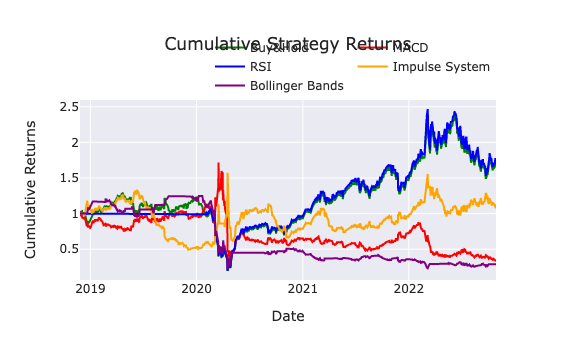

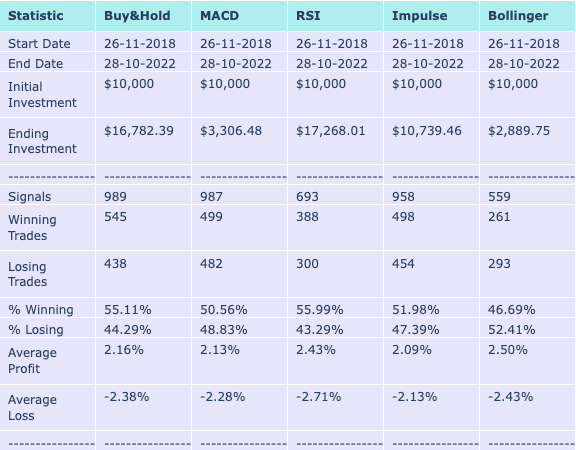

Gold
------------


Gold-Test Period


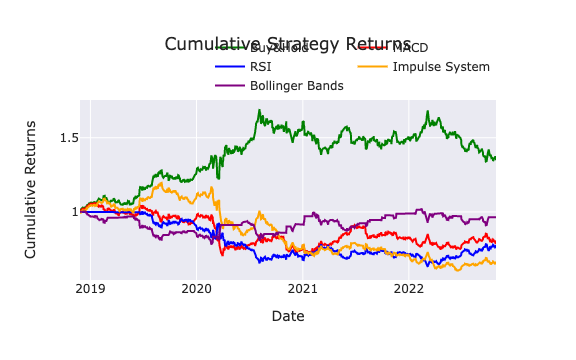

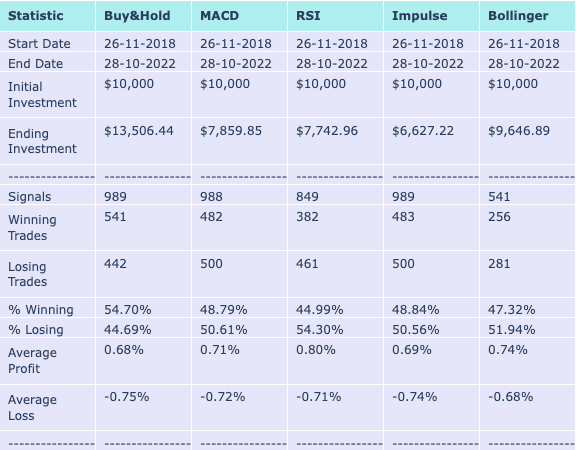

Russel2000
------------


Russel2000-Test Period


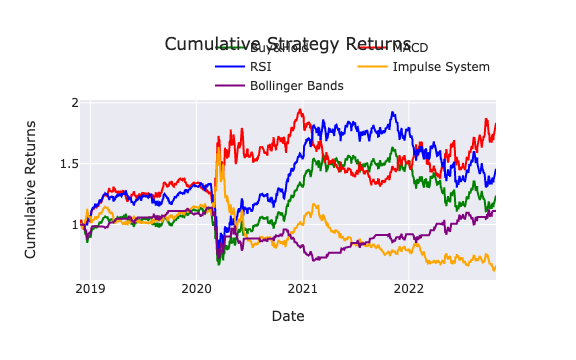

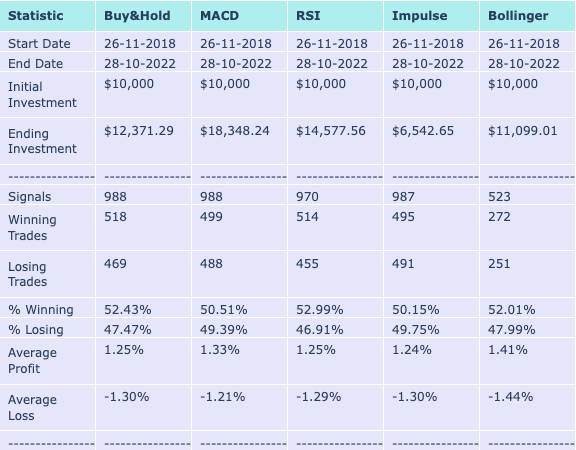

S&P500
------------


S&P500-Test Period


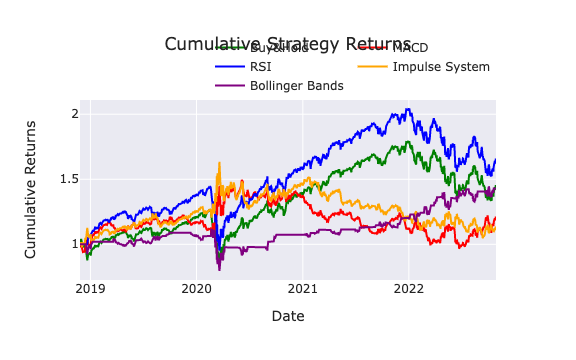

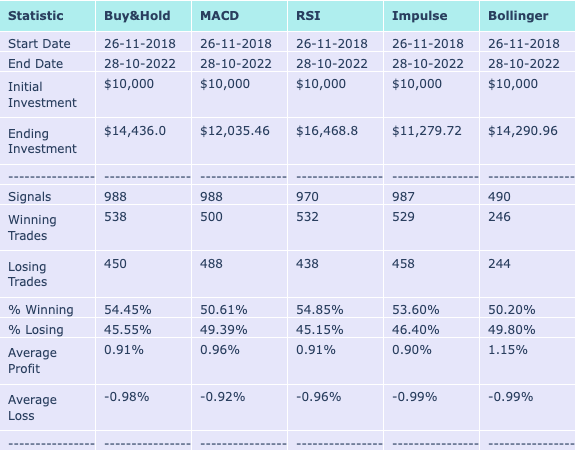

EUR-USD
------------


EUR-USD-Test Period


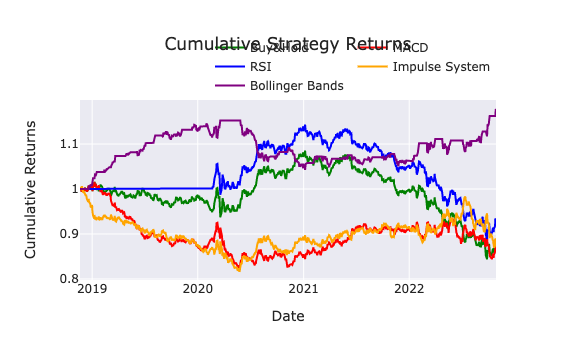

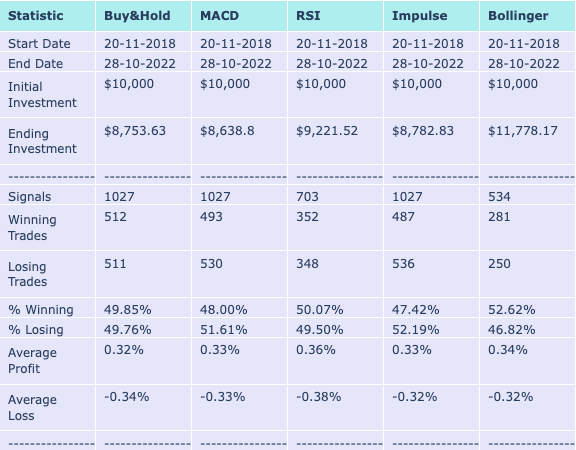

GBP-JPY
------------


GBP-JPY-Test Period


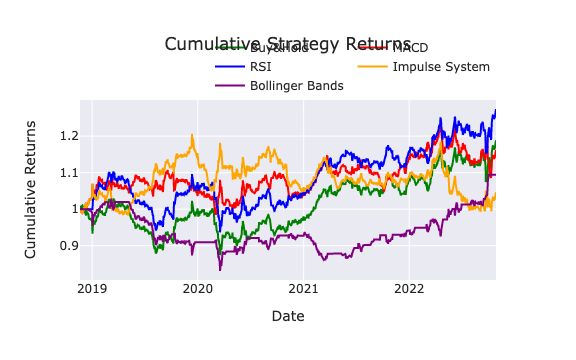

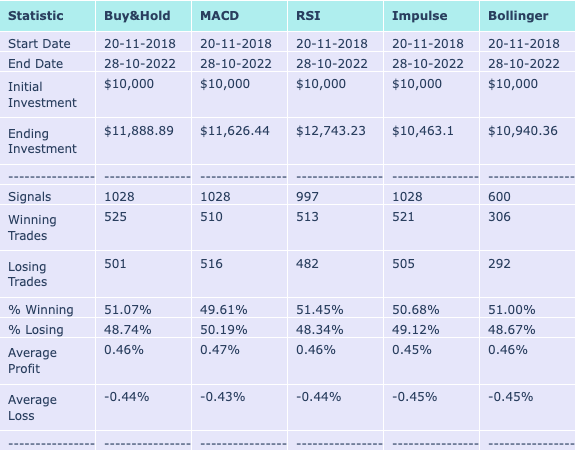

BTC-USD
------------


BTC-USD-Test Period


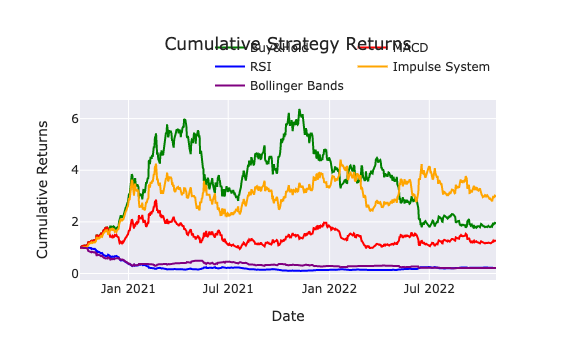

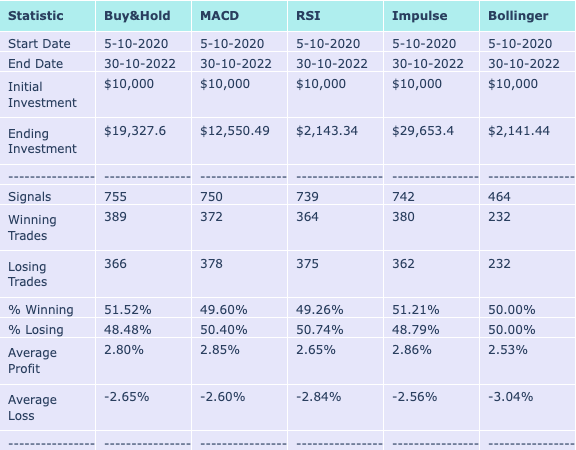

ETH-USD
------------


ETH-USD-Test Period


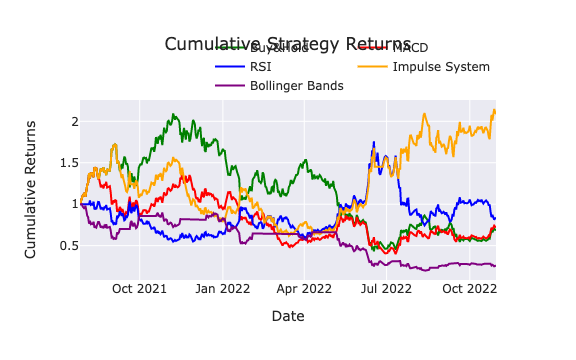

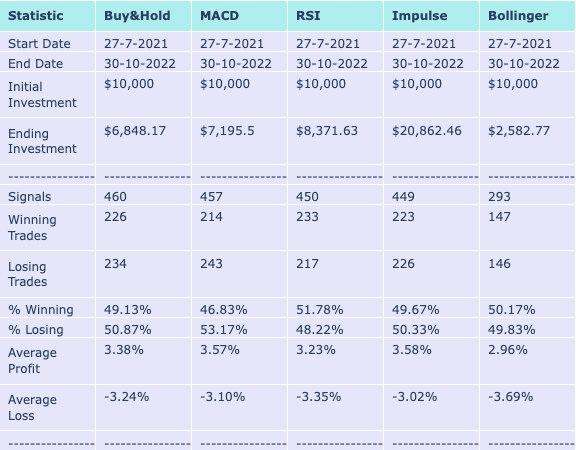

In [16]:
# Get Technical Analysis and Strategy Performance Metrics for all Assets

for i in range(0,len(assetNames)):
    
    # Loading data
    
    file_name = "../Datasets/algoData_"+assetNames[i]+'.csv'
    file_path = Path(file_name)
    algoData = pd.read_csv(file_path)
    algoData.set_index('Date', inplace=True)
    algoData.index = pd.to_datetime(algoData.index)
    
    if(assetNames[i] == 'ETH-USD'):
        training_months = 42
    elif(assetNames[i] == 'BTC-USD'):
        training_months = 70
    else:
        training_months = 145
    
    
    # Split the data into training and test datasets

    # Assign a copy of the aldoData DataFrame
    returns = algoData[algoData.columns]

    # Select the start of the training period
    returns_begin = returns.index.min()

    # Select the ending period for the training data with an offset of x months
    returns_end = returns.index.min() + DateOffset(months=training_months)

    # Generate the taining DataFrames
    returns_train = returns.loc[returns_begin:returns_end]

    # Generate the test DataFrames
    returns_test = returns.loc[returns_end+DateOffset(days=1):]
    
    print(assetNames[i])
    print('------------')
    print('\n')
    
    # Calulate all the Strategy returns for the training period
    #allStrategyReturnsTrain = allReturnsData(returns_train, risk)
    
    #print(assetNames[i]+'-Training Period')

    # Plot the all the Strategy returns for the training period
    #cumulativeStrategyReturnsPlot(allStrategyReturnsTrain, assetNames[i], 'training')

    # Descriptive Statistics for all Strategy returns for the training period
    #descriptiveStats(allStrategyReturnsTrain, initial, riskFree, assetNames[i], 'training')
    
    
    # Calulate all the Strategy returns for the test period
    allStrategyReturnsTest = allReturnsData(returns_test, risk)
    
    results = descriptiveStatsTable(allStrategyReturnsTest, initial, riskFree, assetNames[i])
    
    print(assetNames[i]+'-Test Period')

    # Plot the all the Strategy returns for the test period
    cumulativeStrategyReturnsPlot(allStrategyReturnsTest, assetNames[i])

    # Descriptive Statistics for all Strategy returns for the test period
    descriptiveStats(results, assetNames[i])
    